# To Do
1. Currently implementing Ubc and Vbc
2. After the above the linear solutions for: implicit viscocity, and pressure (WIP), can be implemented.
3. Visualisation
4. Implement cholensky matrices (more efficient)

# Algorithm

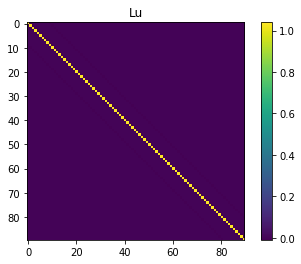

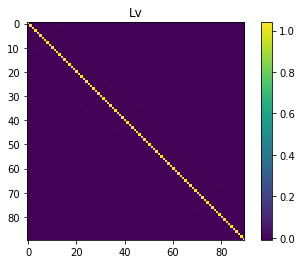

In [16]:
#%matplotlib notebook
import numpy as np
import scipy as sci

import matplotlib.pyplot as plt
from matplotlib import cm

import scipy.sparse as spa
import scipy.sparse.linalg as spala 

from types import SimpleNamespace

# Initial conditions 
const = SimpleNamespace() # Proposal const -> cst
par = SimpleNamespace()

const.Re = 1e2     # Reynolds number
const.dt = 1e-2    # time step
const.tf = 4e-1    # final time
const.lx = 1       # width of box
const.ly = 1       # height of box
const.nx = 10      # number of x-gridpoints
const.ny = 10      # number of y-gridpoints
const.nsteps = 10  # number of steps with graphic output

const.nt = np.ceil(const.tf/const.dt)
const.dt = const.tf/const.nt;

# Constuct grid
const.x, const.y = np.linspace(0, const.lx, const.nx+1), np.linspace(0, const.ly, const.ny+1)
const.hx, const.hy = const.lx/const.nx, const.ly/const.ny
[const.X,const.Y] = np.meshgrid(const.y, const.x);

# IC's
U = np.zeros((const.nx-1, const.ny), dtype = float)
V = np.zeros((const.nx, const.ny-1), dtype = float)

# BC's
## North, East, South, West

uN = const.x*0 + 1
uE = ave(const.y, 'h')*0 
uS = const.x*0 
uW = ave(const.y, 'h')*0

vN = ave(const.x, 'h')*0 
vW = const.y*0
vS = ave(const.x, 'h')*0
vE = const.y*0

# Boundary matrices
#TODO Don't know why there is a factor 2 in front of uS and uN etc.
Ubc = const.dt/const.Re*((np.vstack((2*uS[1:-1], np.zeros((const.nx-1,const.ny-2),dtype=float).T, 2*uN[1:-1])).T)/const.hx**2 +\
                    np.vstack((uW, np.zeros((const.nx-3, const.ny),dtype=float), uE))/const.hy**2)
Vbc = const.dt/const.Re*((np.vstack((vS, np.zeros((const.nx,const.ny-3), dtype = float).T, vN)).T)/const.hx**2 +\
                    np.vstack((2*vW[1:-1], np.zeros((const.nx-2, const.ny-1),dtype=float), 2*vE[1:-1]))/const.hy**2)

# Operator matrices on P, U, V, Q respectively
Lp = spa.kron(spa.eye(const.ny), laplace_m(const.nx, const.hx, 'Neumann')) +\
     spa.kron(laplace_m(const.ny, const.hy, 'Neumann'), spa.eye(const.nx))
#TODO Why 3/2 Lp[0,0]
Lp[0,0] = 3/2*Lp[0,0]   
Lu = spa.eye((const.nx - 1) * const.ny) + \
     (const.dt / const.Re) * ( spa.kron(spa.eye(const.ny), laplace_m(const.nx - 1, const.hx, 'Dirichelt_on') )  + \
     spa.kron( laplace_m(const.ny, const.hy, 'Dirichelt_between'), spa.eye(const.nx - 1) ) )
Lv = spa.eye((const.ny-1)*const.nx) + \
     (const.dt/const.Re)*(spa.kron(spa.eye(const.ny-1), laplace_m(const.nx, const.hx, 'Dirichelt_between'))+\
     spa.kron(laplace_m(const.ny-1, const.hy, 'Dirichelt_on'), spa.eye(const.nx)))
Lq = spa.kron(spa.eye(const.ny-1), laplace_m(const.nx-1, const.hx, 'Dirichlet_on')) +\
     spa.kron(laplace_m(const.ny-1, const.hy, 'Dirichlet_on'), spa.eye(const.nx-1))
np.shape(Lv)       
# Implement pre solution matrices
## WIP
## Need to figure out how to use cholensky with sparse matrices use sksparse.cholmod

# Visualisation of L matrices
#visualise_matrix(Lp, 'Lp')
#visualise_matrix(Lu, 'Lu')
#visualise_matrix(Lv, 'Lv')
#visualise_matrix(Lq, 'Lq')

loop = True
counter = 0

while loop:
    counter += 1
    
    # Non linear terms
    Ue = np.vstack((uW, U, uE)).T
    Ue = np.vstack((2*uS-Ue[0,:], Ue ,2*uN-Ue[-1,:])).T
    Ve = np.vstack((vS, V.T, vN)).T
    Ve = np.vstack((2*vW-Ve[0,:], Ve, 2*vE-Ve[-1,:]))
    
    # If x and y are made 2D
    # This should be more efficient since here vectors are transposed opposed to matrices
    ## Ue = np.concatenate((uS, np.concatenate((uW, U.T, uE), axis = 0).T, uN), axis = 0)
    ## Ve = np.concatenate((vW, np.concatenate((vS.T, V, vN.T), axis = 1), vE), axis = 0)
    
    ## Average and difference matrices
    Ua = ave(Ue, 'v')
    Ud = np.diff(Ue, n=1, axis=1)/2
    Va = ave(Ve, 'h')
    Vd = np.diff(Ve, n=1, axis=0)/2
    
    ## Derivative matrices UV_x and UV_y
    UVx = np.diff((Ua*Va - gamma(const, U, V)*np.abs(Ua)*Vd), axis=0)/const.hx
    UVy = np.diff((Ua*Va - gamma(const, U, V)*Ud*np.abs(Va)), axis=1)/const.hy

    ## Average and difference matrices
    Ua = ave(Ue[:,1:-1], 'h')
    Ud = np.diff(Ue[:,1:-1], n=1, axis=0)/2
    Va = ave(Ve[1:-1,:], 'v')
    Vd = np.diff(Ve[1:-1,:], n=1, axis=1)/2
    
    ## Derivative matrices U^2_x and U^2_y
    U2x = np.diff((Ua**2 - gamma(const, U, V)*np.abs(Ua)*Ud), axis=0)/const.hx
    V2y = np.diff((Ua**2 - gamma(const, U, V)*np.abs(Va)*Vd), axis=1)/const.hy
    
    ## Change in velocity applied
    U = U - const.dt*(UVy[1:-1,:] + U2x)
    V = V - const.dt*(UVx[:,1:-1] + V2y)    
    
    # Implicit viscocity 
    u = spala.spsolve(Lu, np.reshape(U + Ubc,(-1,1)))
    U = np.reshape(u,(const.nx-1, const.ny))
    v = spala.spsolve(Lv, np.reshape(V + Vbc,(-1,1)))
    V = np.reshape(v,(const.nx, const.ny-1))
    
    # Pressure correction
    # WIP, np.diff takes standard the difference over the last exis hence the y axis.
    grad_U = np.diff(np.vstack((uW, U, uE)), n=1, axis=0)/const.hx +\
             np.diff(np.vstack((vS, V.T, vN)).T, n=1, axis=1)/const.hy
    rhs = (1/const.dt)*np.reshape(grad_U,(-1,1))
    p = -spala.spsolve(Lp, rhs)
    P = np.reshape(p,(const.nx,const.ny))    
    U = U - np.diff(P, n=1, axis=0)/const.hx*const.dt
    V = V - np.diff(P, n=1, axis=1)/const.hy*const.dt 

    # Visualization
    '''
    [X, Y] = np.meshgrid(ave(const.x, 'h'), ave(const.y, 'h'))
    
    if counter%const.nsteps==0 or counter == 1:
        print('Counter: ' + str(counter) + ',', 'Time: ' + str(const.dt*counter) + ' s')
        # WIP 
        # Add velocity contour arrows and possibly Q
        # Would suggest that we make movies like so: 
        # https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python
        fig = plt.figure()
        contour = plt.pcolormesh(X, Y, P.T)
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
    '''
    if counter == np.ceil(const.tf/const.dt):
        loop = False


# Functions

In [1]:
def ave(A, axis):
    """
    axis = h(orizontal), v(ertical) 
    """
    if axis == 'v':
        A = np.transpose(A)
        
    average = (A[0:-1] + A[1:])/2
    
    if axis == 'v':
        average = np.transpose(average)
    
    return average

def gamma(const, U, V):
    """
    Returns gamma factor
    """
    return np.min((1.2*const.dt*np.max((np.max((np.abs(U)/const.hx)), np.max((np.abs(V)/const.hy)))), 1))

def laplace_m(n, h, bc):
    diag_len = n 
    Lm = 2*np.ones(diag_len)  # Create diagonal values 
    Lu = np.diag(-1*np.ones(diag_len-1), k=1) # Up offdiagonal value 
    Ld = np.diag(-1*np.ones(diag_len-1), k=-1)# Down offdiagonal value 
   
    if bc == 'Neumann':
        Lm[[0,-1]] = 1 
        
    if bc == 'Dirichelet_on':
        Lm[[0,-1]] = 2 
    
    if bc == 'Dirichelet_between':
        Lm[[0,-1]] = 3 
    
    Lm=np.diag(Lm, k=0)
    
    L = (Lu + Lm + Ld)/h**2
    return L

def visualise_matrix(matrix, label_title):
    """ Visualises matrix by making 2D colourplot.
    
    Parameters
    ----------
    matrix : 2D numpy.ndarray or scipy.sparse.bsr.bsr_matrix
        
    """
    if isinstance(matrix, np.ndarray):
        matrix_plot = matrix
    elif isinstance(matrix, spa.bsr.bsr_matrix) or isinstance(matrix, spa.coo.coo_matrix) or spa.csr.csr_matrix:
        matrix_plot = matrix.toarray()
    plt.imshow(matrix_plot)
    plt.colorbar()
    plt.clim(np.min(matrix_plot), np.max(matrix_plot))
    plt.title(label_title)
    plt.show()

In [ ]:
# This is usefull to get an idea of how the matrices are becoming what they are.
# Use nx and ny to be 4 to see the similarities
plt.spy(Lv)
plt.show()
plt.spy(spa.kron(spa.eye(3), laplace_m(4, 1, 'Neumann')))
plt.show()
plt.spy(spa.kron(laplace_m(4, 1, 'Neumann'), spa.eye(3)))
plt.show()

visualise_matrix(spa.kron(spa.eye(3), laplace_m(4, 1, 'Neumann')))
visualise_matrix(spa.kron(laplace_m(4, 1, 'Neumann'), spa.eye(3)))


In [ ]:
import sksparse.cholmod as skch

print(skch.cholesky(Lp))